## Simulating random signals

using Poisson, Gaussian and Uniform

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from umap import UMAP
from scipy.ndimage import uniform_filter1d
from scipy.stats import zscore
from sklearn.decomposition import PCA

In [2]:
# @title Data retrieval
# this retrieves the dataset if not already in the folder

import os, requests

fname = "stringer_spontaneous.npy"
url = "https://osf.io/dpqaj/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [3]:
dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])


# Todos
## get plausible lambda for Poisson

- exclude 0s, then fit poissons to bin rate
- $\lambda = mean$

## get plausible lambda for Exponential

- exclude 0s, then fit exponentials to bin rate
- $\lambda = \frac{1}{mean}$

## get plausible Normal parameters

- doing the same with mean and std

## get plausible number of 0s

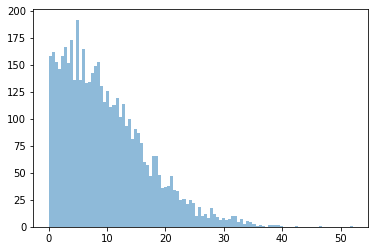

In [11]:
plt.hist(dat['sresp'][0][dat['sresp'][0] > 0], bins = 100, alpha = .5) # histogram without zeros
plt.show()

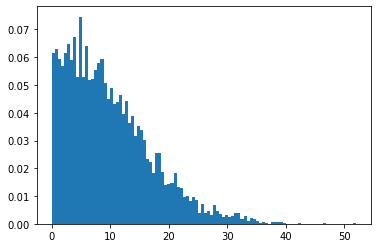

In [6]:
# dat_clean contains data from one neuron without 0s
dat_clean = dat['sresp'][0][dat['sresp'][0] > 0]
#bins = np.arange(50) - 0.5

plt.hist(dat_clean, bins=100, density=True, label='Data')
plt.show()

In [8]:
mean = dat_clean.mean()

In [9]:
# simualte one synthetic neuron
rate = 10
neuron = np.random.exponential(1/mean, 7018)
#neuron = np.random.poisson(mean, 7018)

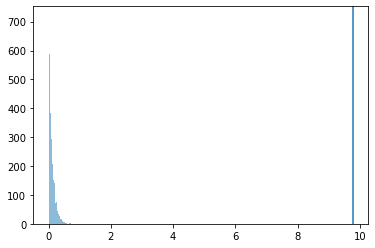

In [11]:
plt.hist(neuron, bins = 100, alpha = .5)
#plt.hist(dat_clean, bins = 100, alpha = .5)

plt.axvline(mean)
plt.show()

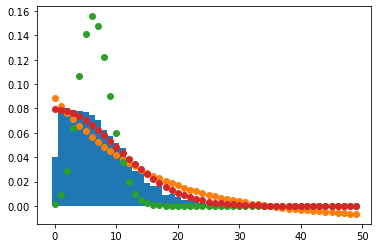

In [33]:
## potential poisson-fitting code
from scipy.optimize import curve_fit
from scipy.special import factorial
from scipy.stats import poisson
from scipy.stats import halfnorm

i = 1 # index of neuron to look at
dat_clean = dat['sresp'][i][dat['sresp'][i] > 0]

# the bins should be of integer width, because poisson is an integer distribution
bins = np.arange(50) - 0.5
entries, bin_edges, patches = plt.hist(dat_clean, bins=bins, density=True, label='Data')

# calculate bin centres
bin_middles = 0.5 * (bin_edges[1:] + bin_edges[:-1])

def fit_halfnorm(k, s):
    '''poisson function, parameter lamb is the fit parameter'''
    return halfnorm.pdf(k, 0, s)

def fit_function(k, lamb):
    '''poisson function, parameter lamb is the fit parameter'''
    return poisson.pmf(k, lamb)

def monoExp(x, m, t, b):
    return m * np.exp(-t * x) + b


## exp fit
# fit with curve_fit
p0 = (2000, .1, 50) # start with values near those we expect
parameters, cov_matrix = curve_fit(monoExp, bin_middles, entries, p0 = p0)

# plot exp-deviation with fitted parameter
x_plot = np.arange(0, 50)

## Poisson fit
# fit with curve_fit
p0 = 10 # start with values near those we expect
parameters_p, cov_matrix_p = curve_fit(fit_function, bin_middles, entries, p0 = p0)

## Halfgaussian fit
# fit with curve_fit
p0 = 1 # start with values near those we expect
parameters_n, cov_matrix_n = curve_fit(fit_halfnorm, bin_middles, entries, p0 = p0)



# plot exp-deviation with fitted parameter
x_plot = np.arange(0, 50)

plt.plot(
    x_plot,
    monoExp(x_plot, *parameters),
    marker='o', linestyle='',
    label='Fit result',
)

plt.plot(
    x_plot,
    fit_function(x_plot, *parameters_p),
    marker='o', linestyle='',
    label='Fit result',
)
plt.plot(
    x_plot,
    fit_halfnorm(x_plot, *parameters_n),
    marker='o', linestyle='',
    label='Fit result',
)

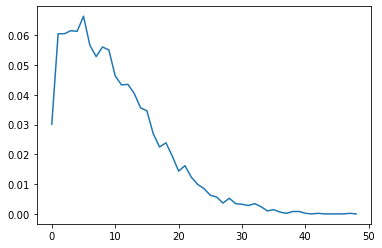

In [17]:
plt.plot(bin_middles, entries)

In [19]:
bin_middles

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48.])

In [18]:
entries

array([0.03013754, 0.06047735, 0.06047735, 0.06148867, 0.06128641,
       0.06634304, 0.0566343 , 0.05279126, 0.05602751, 0.05501618,
       0.04631877, 0.04328479, 0.04348706, 0.04045307, 0.03559871,
       0.03458738, 0.02690129, 0.02245146, 0.02386731, 0.01941748,
       0.01436084, 0.01618123, 0.01233819, 0.009911  , 0.00849515,
       0.00627023, 0.00566343, 0.00364078, 0.0052589 , 0.00343851,
       0.00323625, 0.00283172, 0.00343851, 0.00242718, 0.00101133,
       0.00141586, 0.0006068 , 0.00020227, 0.00080906, 0.00080906,
       0.00020227, 0.        , 0.00020227, 0.        , 0.        ,
       0.        , 0.        , 0.00020227, 0.        ])

# misc

In [ ]:
# syntax for instantiating normal and poisson
# add another parameter for size
np.random.normal(mean, std)
np.random.poisson(rate)
np.random.exponential(rate)